# 1. Initial Setup & Data Loading

Explanation:
This segment loads the dataset and converts the date column to a datetime object. The date column is then set as the index for easier time-based manipulations. The data.info() and data.head() help inspect the structure of the data.

In [4]:
import pandas as pd
import numpy as np
import holidays
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'energydata_complete.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Convert 'date' column to datetime with day first and set it as the index
data['date'] = pd.to_datetime(data['date'], dayfirst=True)
data.set_index('date', inplace=True)

# Display basic info to understand the data structure
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9         

# 2. Feature Engineering: Time-Based Features and Holiday Flags

Explanation:
Here, we add hour, day_of_week, and month as time-based features. Additionally, we create an is_holiday flag using the holidays library and a season feature that categorizes the month into one of the four seasons.

In [5]:
# Add time-based features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

# Holiday indicator (using the holidays library)
holiday_list = holidays.CountryHoliday('US')  # Replace 'US' with your country code
data['is_holiday'] = data.index.isin(holiday_list.keys()).astype(int)

# Create seasonal flags (Winter, Spring, Summer, Fall)
seasons = {12: 'Winter', 1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
           6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall'}
data['season'] = data.index.month.map(seasons)


# 3. Temperature-Related Features

Explanation:
The T_diff feature is calculated as the difference between the outdoor temperature (T_out) and the baseline average temperature. Additionally, the T_out_smooth feature is a rolling average of the outdoor temperature, which can capture more stable trends.

In [6]:
# Calculate temperature difference from baseline (mean temperature)
baseline_temperature = data['T_out'].mean()
data['T_diff'] = data['T_out'] - baseline_temperature

# Smooth temperature with a rolling mean (3-hour window)
data['T_out_smooth'] = data['T_out'].rolling(window=3).mean()


# 4. Lag Features

Explanation:
Lag features are added to capture time dependencies. For example, Appliances_lag_1 represents the energy consumption of the previous hour, and T_out_lag_1 represents the outdoor temperature from the previous hour.

In [7]:
# Create lag features for Appliances and other relevant features
data['Appliances_lag_1'] = data['Appliances'].shift(1)
data['Appliances_lag_3'] = data['Appliances'].shift(3)
data['T_out_lag_1'] = data['T_out'].shift(1)
data['T_out_lag_3'] = data['T_out'].shift(3)


# 5. Rolling Statistics

Explanation:
We add rolling statistics (rolling_mean and rolling_std) to capture trends and volatility in energy consumption over a 5-hour rolling window.

In [8]:
# Calculate rolling mean and standard deviation for appliances consumption
data['Appliances_rolling_mean'] = data['Appliances'].rolling(window=5).mean()
data['Appliances_rolling_std'] = data['Appliances'].rolling(window=5).std()


# 6. Time-of-Day Flags

Explanation:
These flags capture different times of the day (morning, afternoon, evening) to understand if energy consumption patterns vary by time of day.

In [9]:
# Flag for time of day (morning, afternoon, evening)
data['is_morning'] = ((data.index.hour >= 6) & (data.index.hour < 12)).astype(int)
data['is_afternoon'] = ((data.index.hour >= 12) & (data.index.hour < 18)).astype(int)
data['is_evening'] = ((data.index.hour >= 18) & (data.index.hour < 24)).astype(int)


# 7. Interaction Features

Explanation:
We introduce interaction terms like T_out_hour_interaction, which combines outdoor temperature and hour of the day, and T_out_day_of_week_interaction, combining temperature with the day of the week.

In [10]:
# Interaction terms between temperature and time-based features
data['T_out_hour_interaction'] = data['T_out'] * data['hour']
data['T_out_day_of_week_interaction'] = data['T_out'] * data['day_of_week']


# 8. Weekend vs Weekday Feature

Explanation:
This feature helps distinguish between weekends and weekdays, which could have different energy consumption patterns.

In [11]:
# Flag for weekends (Saturday = 5, Sunday = 6)
data['is_weekend'] = data.index.weekday >= 5  # Saturday = 5, Sunday = 6


# 9. Creating Feature Matrix and Target Variable

Explanation:
This segment prepares the final dataset for training. We select relevant features, normalize them using MinMaxScaler, and create time-series data by creating sequences of past observations. We also split the data into training, validation, and test sets.

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Handle categorical variables with one-hot encoding
# One-hot encode 'season' column and drop the first column to avoid dummy variable trap
data = pd.get_dummies(data, columns=['season'], drop_first=True)

# Select features for modeling
selected_features = [
    'T_out', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2',
    'hour', 'day_of_week', 'month', 'is_holiday', 'T_diff', 'T_out_smooth',
    'Appliances_lag_1', 'Appliances_lag_3', 'T_out_lag_1', 'T_out_lag_3', 'Appliances_rolling_mean',
    'Appliances_rolling_std', 'is_morning', 'is_afternoon', 'is_evening', 'T_out_hour_interaction',
    'T_out_day_of_week_interaction', 'is_weekend'
]

# Create the feature matrix and target variable
features = data[selected_features]
target = data['Appliances']

# Normalize the features (using MinMaxScaler)
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Prepare the data for time-series forecasting
time_steps = 10  # Number of past hours to look at
def create_time_series_data(features, target, time_steps=10):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

X, y = create_time_series_data(features_scaled, target.values, time_steps)

# Split the data into training, validation, and test sets (70%, 20%, 10%)
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]


# 10. Model Building: LSTM

Explanation:
The LSTM model is defined with two LSTM layers, each followed by a dropout layer for regularization. The model is compiled using the Adam optimizer and mean squared error loss, suitable for regression tasks.

In [21]:
X_train = np.clip(X_train, -1e3, 1e3)
y_train = np.clip(y_train, -1e3, 1e3)
X_val = np.clip(X_val, -1e3, 1e3)
y_val = np.clip(y_val, -1e3, 1e3)
X_test = np.clip(X_test, -1e3, 1e3)
y_test = np.clip(y_test, -1e3, 1e3)


In [22]:
from tensorflow.keras.optimizers import Adam

# Compile the model with gradient clipping
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


In [23]:
def custom_mse(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred) + 1e-9

model.compile(optimizer=optimizer, loss=custom_mse, metrics=['mae'])


In [24]:
import numpy as np

# Check if any NaN or infinite values exist in the datasets
print("NaN in X_train:", np.isnan(X_train).any())
print("NaN in y_train:", np.isnan(y_train).any())
print("NaN in X_val:", np.isnan(X_val).any())
print("NaN in y_val:", np.isnan(y_val).any())
print("NaN in X_test:", np.isnan(X_test).any())
print("NaN in y_test:", np.isnan(y_test).any())

print("Inf in X_train:", np.isinf(X_train).any())
print("Inf in y_train:", np.isinf(y_train).any())
print("Inf in X_val:", np.isinf(X_val).any())
print("Inf in y_val:", np.isinf(y_val).any())
print("Inf in X_test:", np.isinf(X_test).any())
print("Inf in y_test:", np.isinf(y_test).any())


NaN in X_train: False
NaN in y_train: False
NaN in X_val: False
NaN in y_val: False
NaN in X_test: False
NaN in y_test: False
Inf in X_train: False
Inf in y_train: False
Inf in X_val: False
Inf in y_val: False
Inf in X_test: False
Inf in y_test: False


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define a custom MSE loss function
def custom_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred)) + 1e-9

# Define the LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile with gradient clipping
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=custom_mse, metrics=['mae'])

# Display the model summary
model.summary()

# Use EarlyStopping to avoid overfitting and potential NaNs during training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')


/home/icelake2/jupyter_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,001 (140.63 KB)

 Trainable params: 36,001 (140.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1732249729.856143   15861 cuda_dnn.cc:529] Loaded cuDNN version 90300


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 19909.2910 - mae: 95.3600 - val_loss: 15063.4482 - val_mae: 83.1136
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 19696.1074 - mae: 88.0147 - val_loss: 13982.3135 - val_mae: 76.3322
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 17727.1914 - mae: 80.1998 - val_loss: 12756.0059 - val_mae: 67.8809
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16694.6523 - mae: 72.2397 - val_loss: 11458.5928 - val_mae: 57.8658
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 15733.8242 - mae: 63.3971 - val_loss: 10214.8193 - val_mae: 47.2026
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 14343.3086 - mae: 56.7979 - val_loss: 9160.1328 - val_mae: 41.2327
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 12896.0664 - mae: 54.5826 - val_loss: 8429.0967 - val_mae: 43.5784
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 12223.0557 - mae: 58.1713 - val_loss: 8162.2534 - val_mae: 48.9665

# 11. Model Training and Evaluation

Explanation:
The model is trained for 50 epochs with validation data, and then evaluated on the test set. The test_loss and test_mae metrics are printed to assess performance.

In [50]:
# # Train the model
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

# # Evaluate the model on the test set
# test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
# print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')


# 12. Plotting the Applications Data:

At the end, we can visualize the Appliances column to see how the energy consumption evolves over time.

### Explanation of Plotting:

This plot shows how the energy consumption of appliances changes over time. It's helpful for visualizing trends and potential seasonality in energy usage. The Appliances column is plotted against the datetime index to observe its time-based variation.

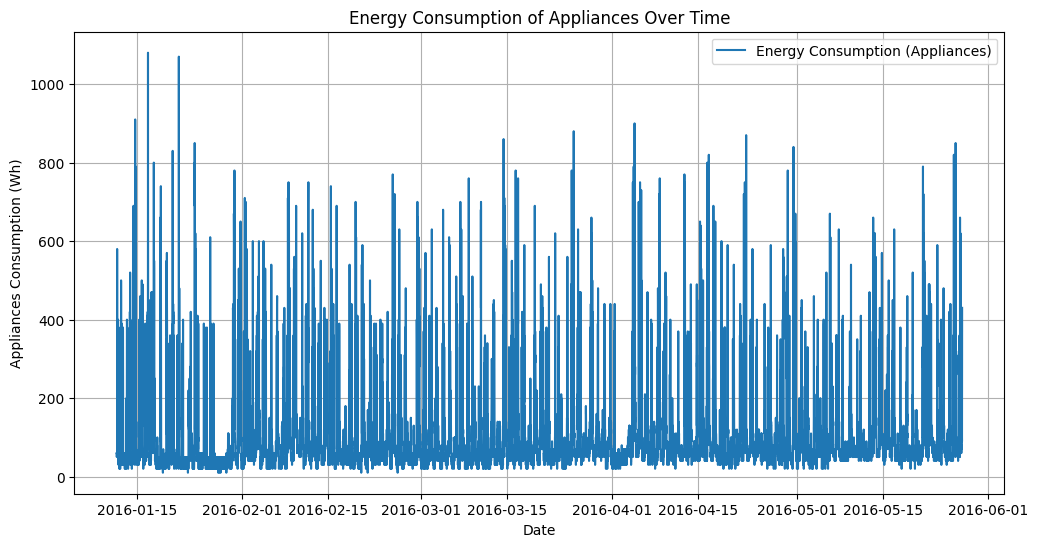

In [26]:
# Plot the Appliances data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Appliances'], label='Energy Consumption (Appliances)', color='tab:blue')
plt.title('Energy Consumption of Appliances Over Time')
plt.xlabel('Date')
plt.ylabel('Appliances Consumption (Wh)')
plt.legend()
plt.grid(True)
plt.show()


# 13. Energy Consumption Over Time (Time-Series Plot)

This plot shows how the energy consumption (i.e., Appliances column) fluctuates over time. It helps to visualize trends, seasonality, and possible outliers in the dataset.

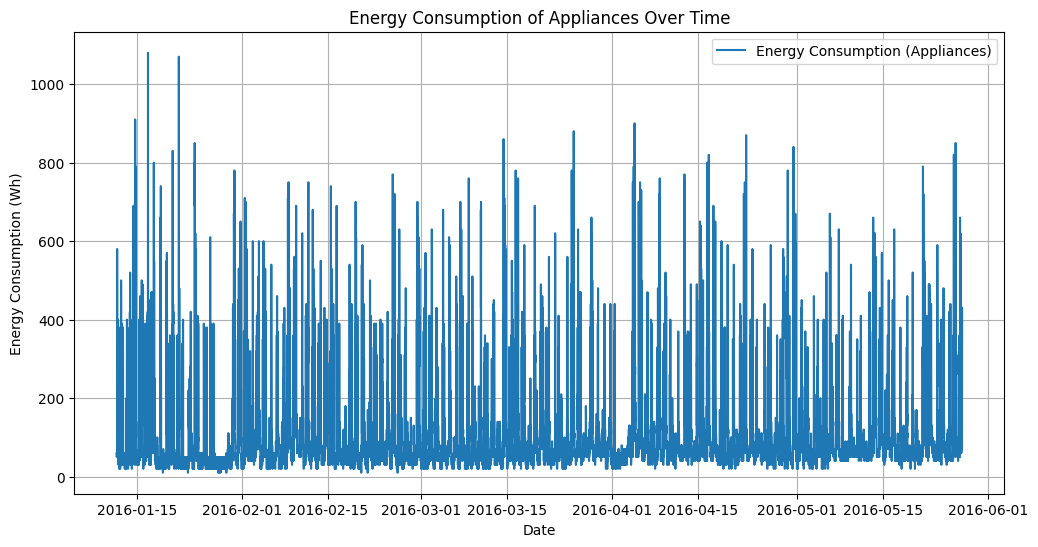

In [27]:
# Plot the energy consumption (Appliances) over time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Appliances'], label='Energy Consumption (Appliances)', color='tab:blue')
plt.title('Energy Consumption of Appliances Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (Wh)')
plt.legend()
plt.grid(True)
plt.show()


# 14. Correlation Heatmap

This heatmap allows you to visualize the relationships between different features and the target variable (Appliances). Strong correlations can provide insights into the factors that affect energy consumption.

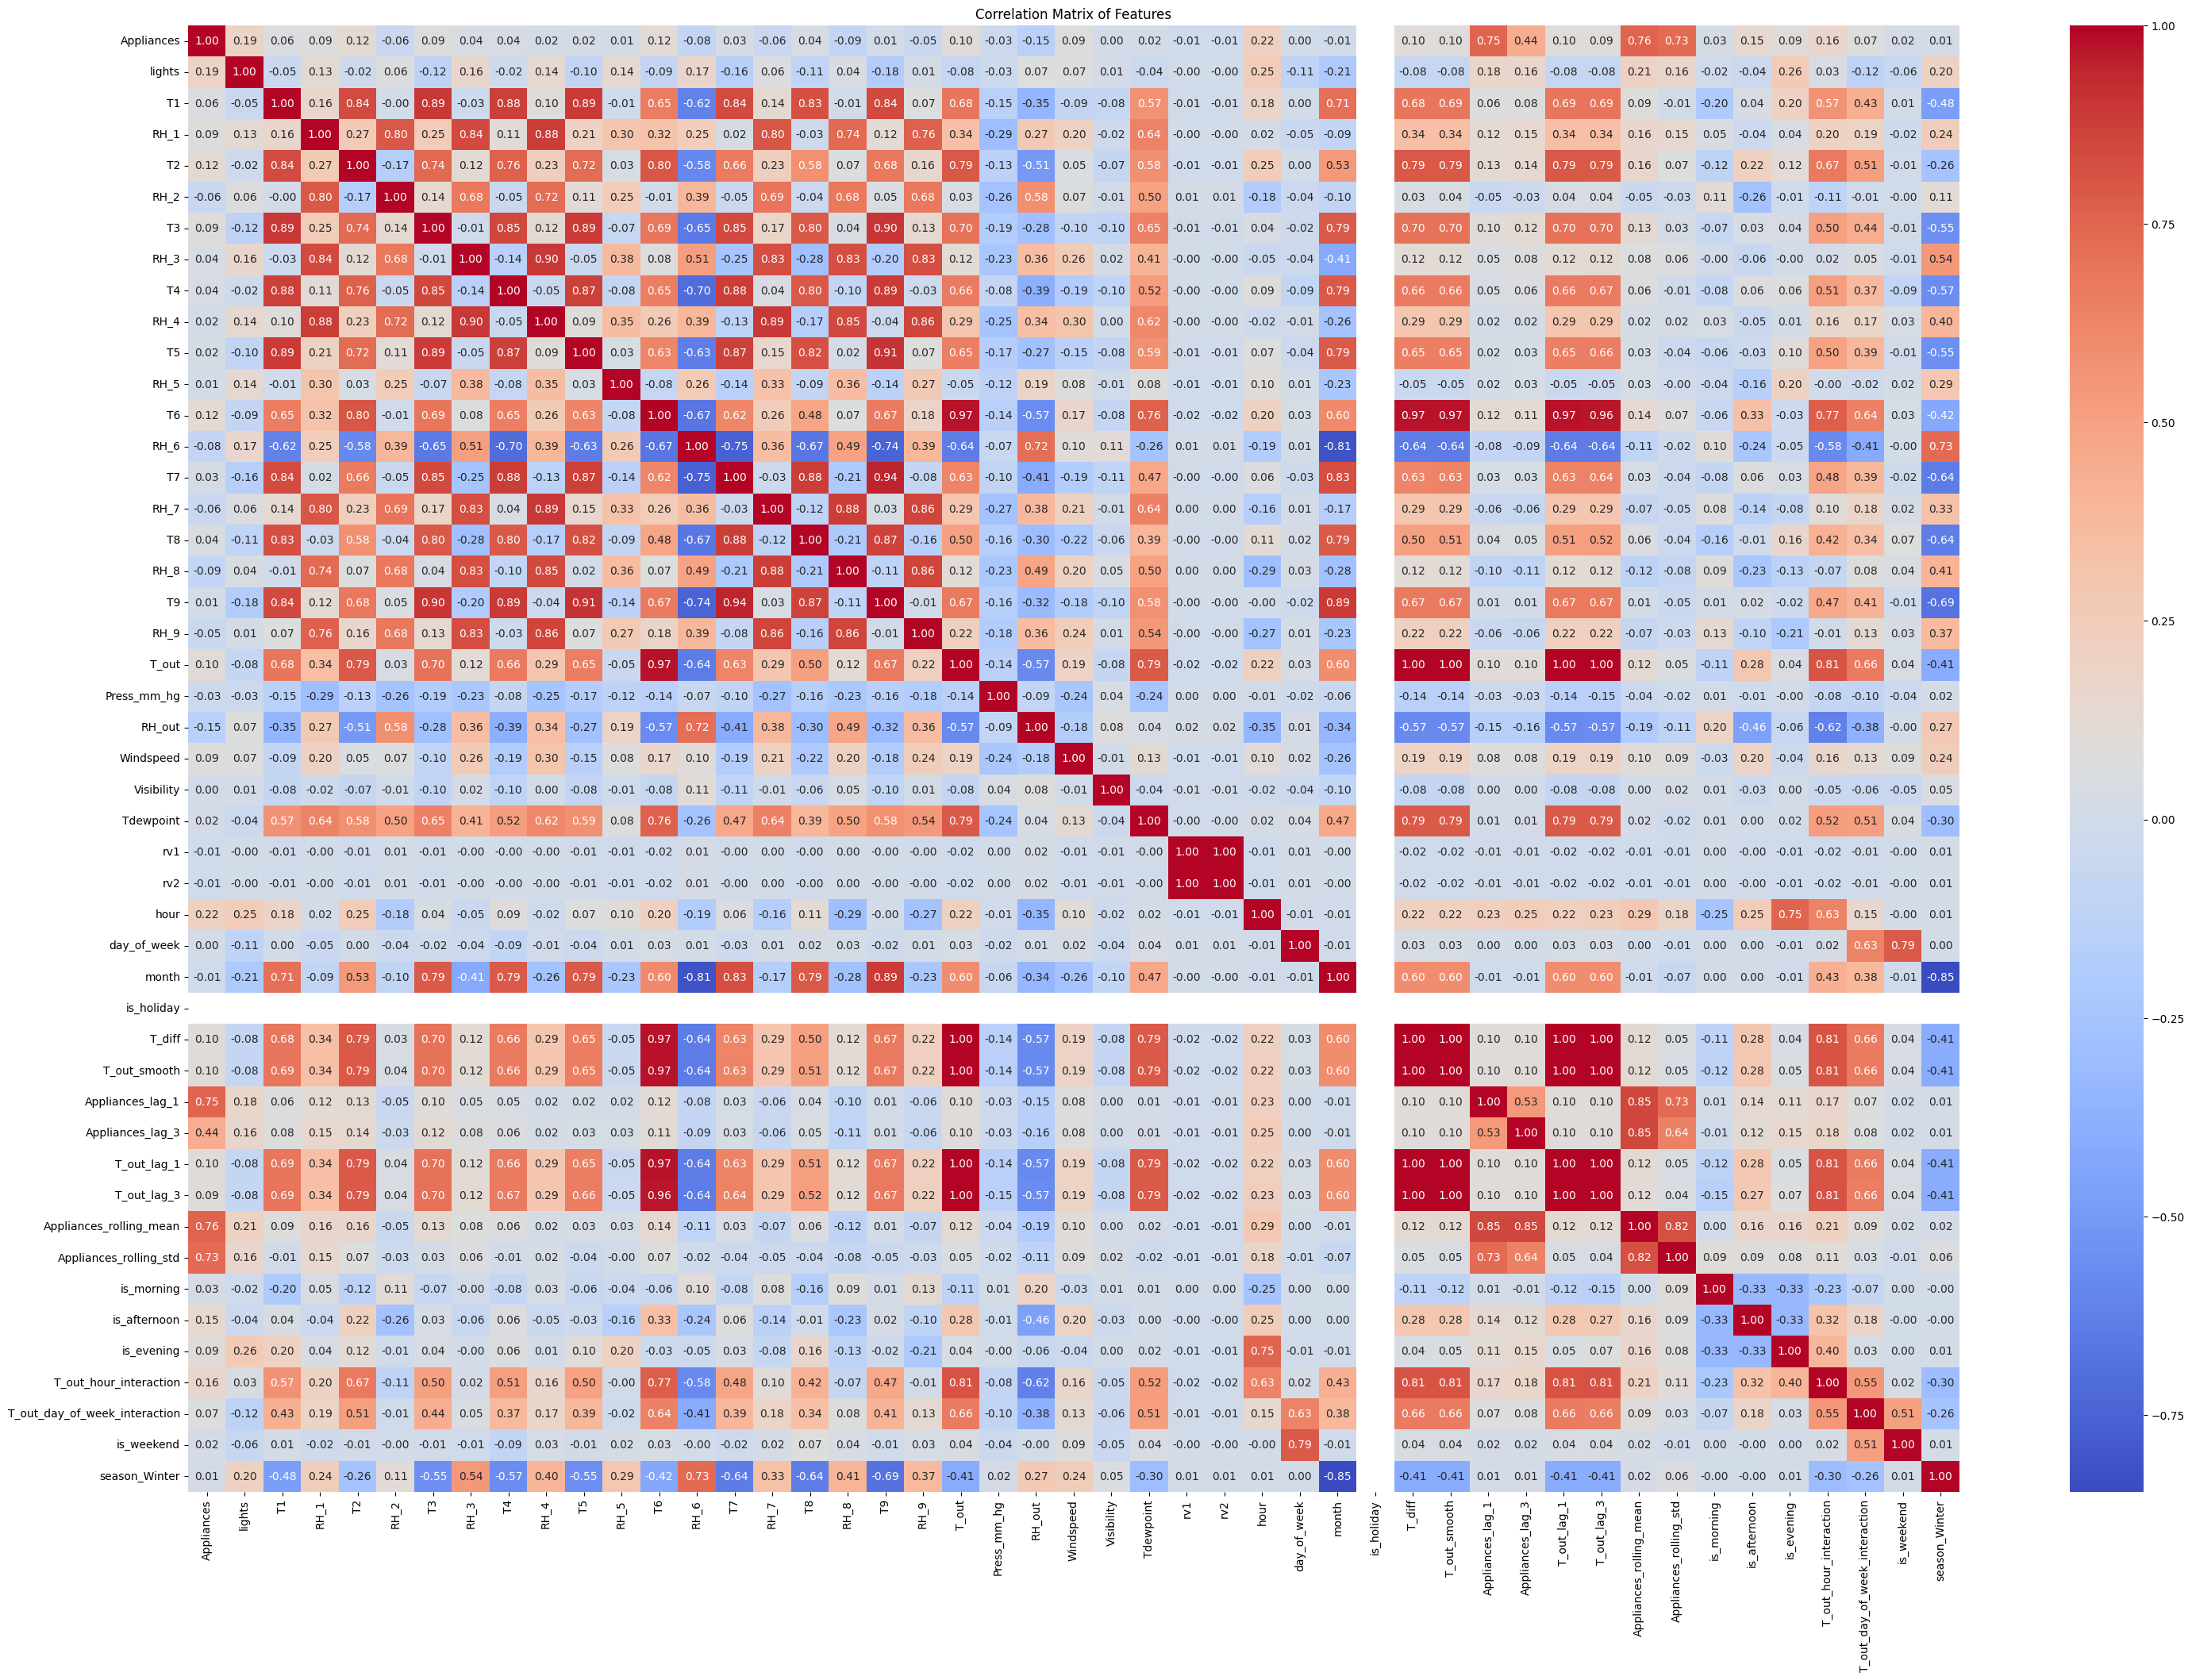

In [28]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(36, 24))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()


# 15. Predictions vs Actuals (for Regression Models)

If you've trained a model (e.g., LSTM or Random Forest) to predict energy consumption, you can plot the predicted values against the actual values. This is useful for assessing how well your model performs.

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


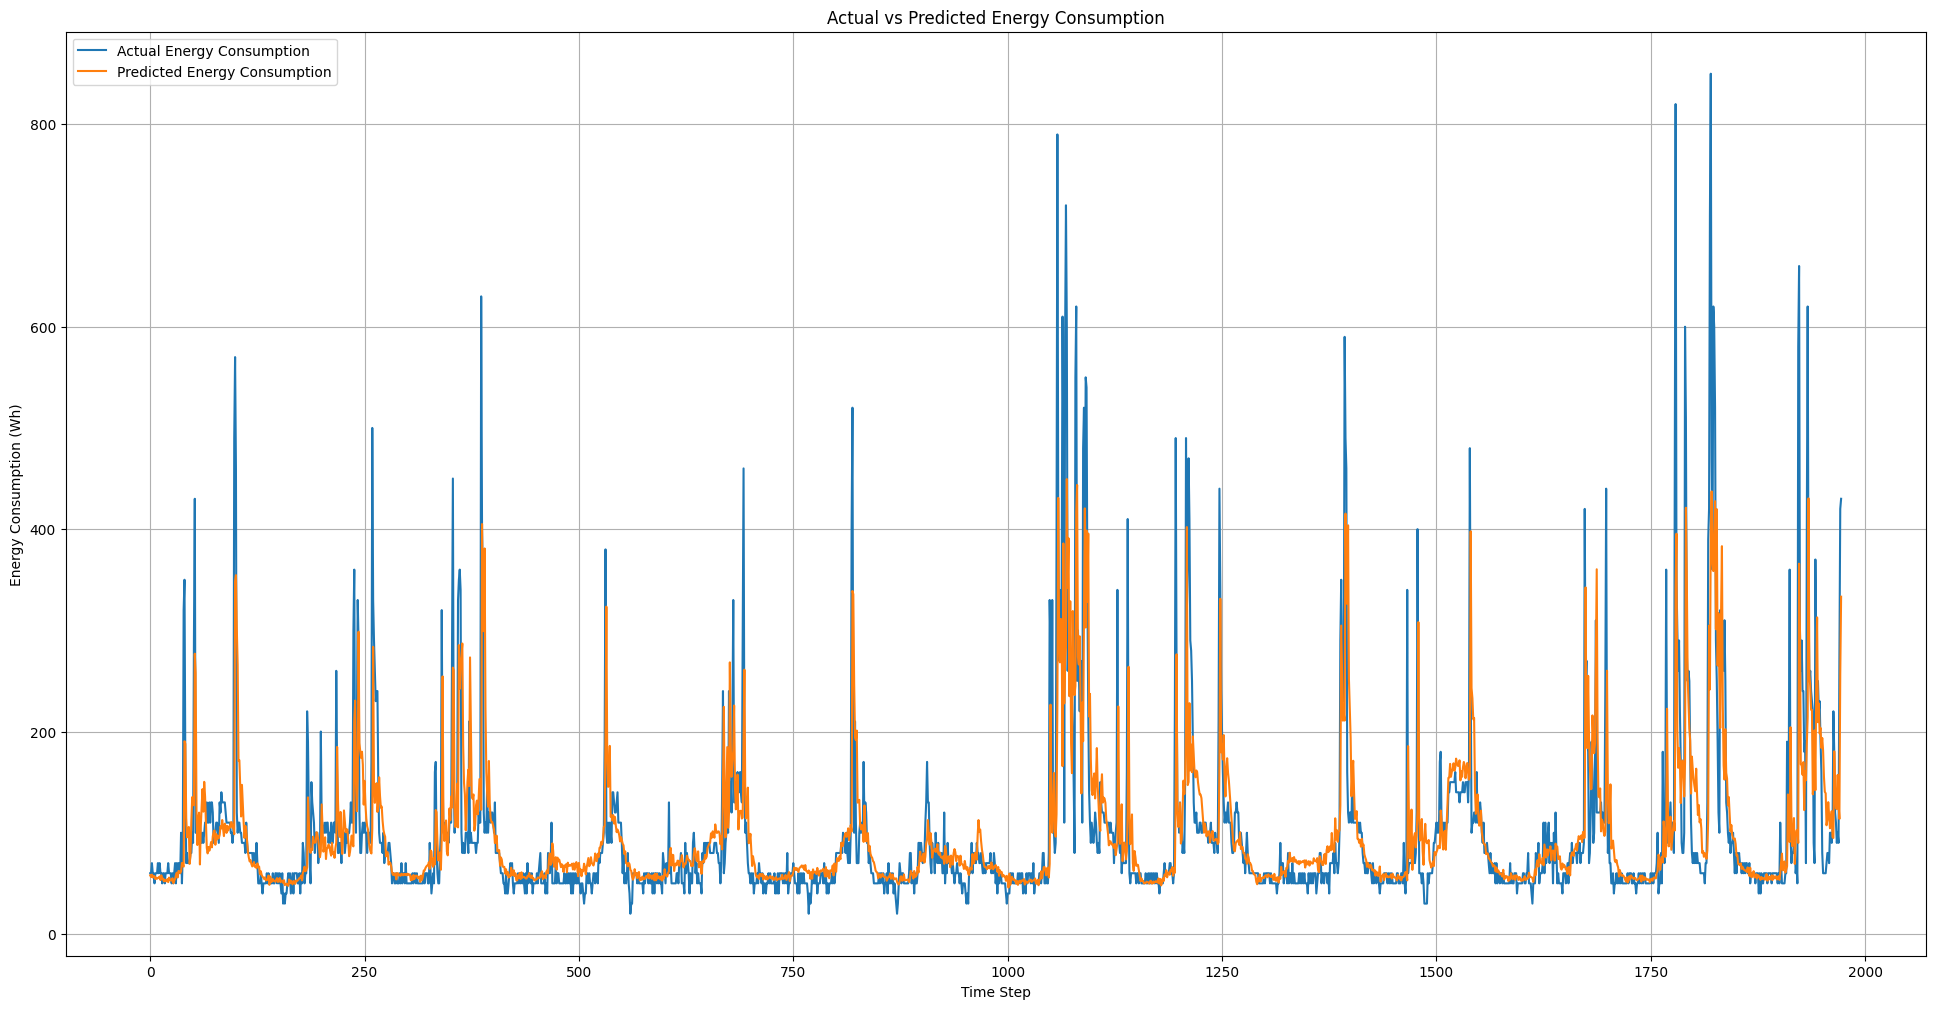

In [31]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(24, 12))
plt.plot(y_test, label='Actual Energy Consumption', color='tab:blue')
plt.plot(y_pred, label='Predicted Energy Consumption', color='tab:orange')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Time Step')
plt.ylabel('Energy Consumption (Wh)')
plt.legend()
plt.grid(True)
plt.show()


# 16. Seasonal Decomposition Plot

For understanding seasonal patterns in energy consumption, you can use a seasonal decomposition plot that breaks down the time-series data into trend, seasonal, and residual components.

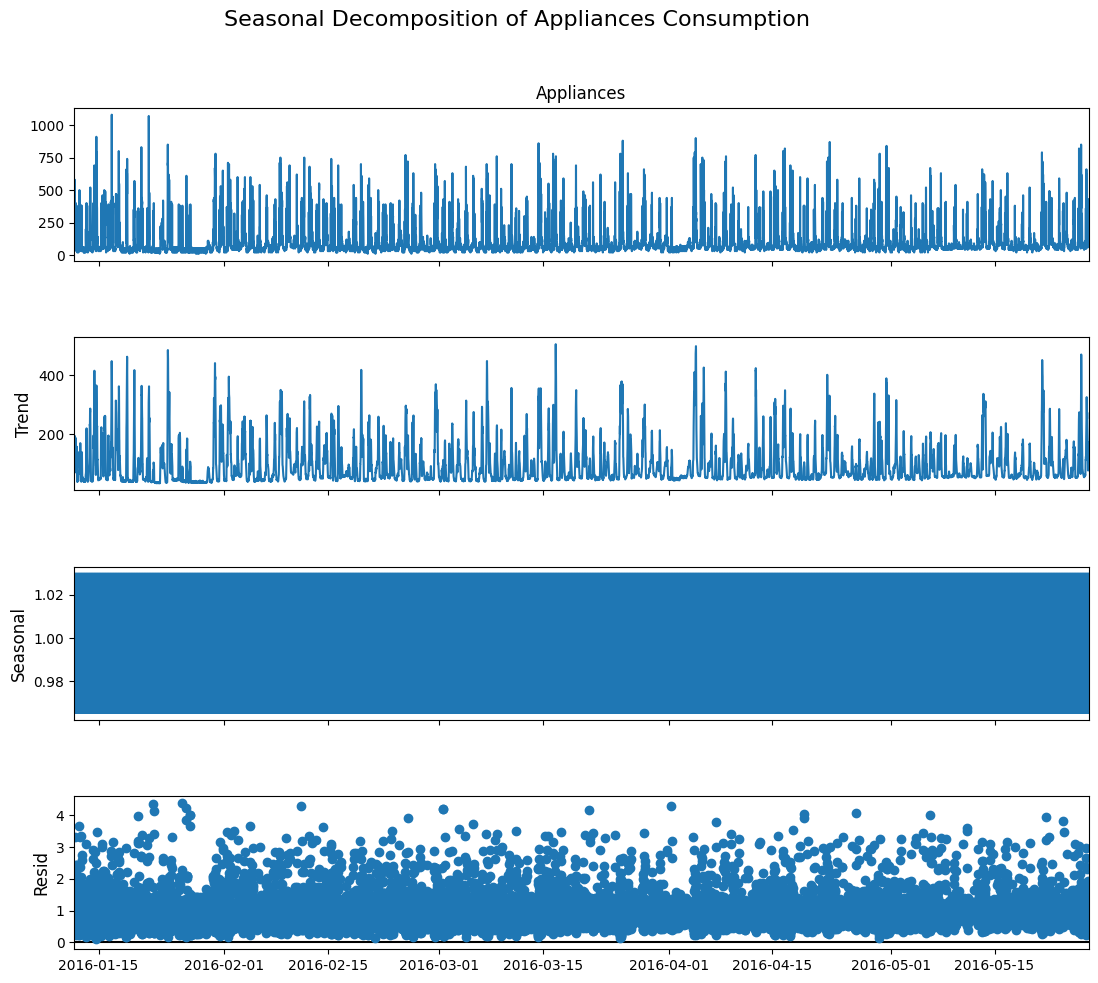

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decompose the 'Appliances' column to observe trend, seasonality, and residuals
decomposition = seasonal_decompose(data['Appliances'], model='multiplicative', period=12)  # assuming daily seasonality

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(12, 10)  # Increase the figure size for better visibility

# Adjust subplot spacing and titles
plt.subplots_adjust(hspace=0.5)  # Add space between subplots
fig.suptitle('Seasonal Decomposition of Appliances Consumption', fontsize=16, y=1.02)  # Title with proper alignment

# Improve individual subplot labels and tick parameters
for ax in fig.axes:
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

plt.show()


# 17. Energy Consumption Distribution (Histogram)

You can visualize the distribution of energy consumption to understand if it's skewed, normally distributed, or if there are any noticeable patterns.

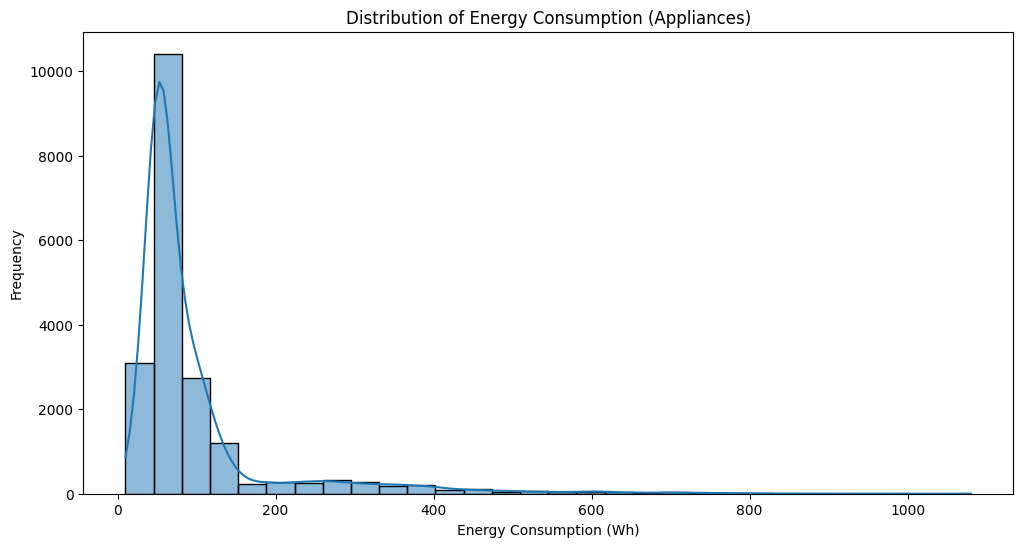

In [33]:
# Plot the distribution of energy consumption (Appliances)
plt.figure(figsize=(12, 6))
sns.histplot(data['Appliances'], kde=True, bins=30, color='tab:blue')
plt.title('Distribution of Energy Consumption (Appliances)')
plt.xlabel('Energy Consumption (Wh)')
plt.ylabel('Frequency')
plt.show()


# 18. Cyclic Feature Effects (e.g., Hour and Day of the Week)

You can also visualize the impact of cyclic features (e.g., hour_sin, hour_cos, day_sin, day_cos) to see how energy consumption changes during different times of day or days of the week.

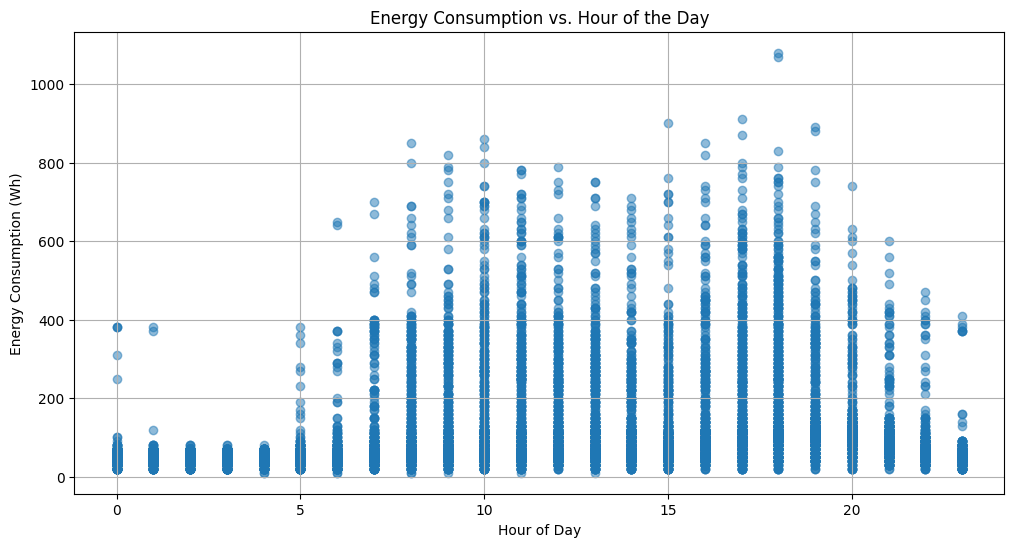

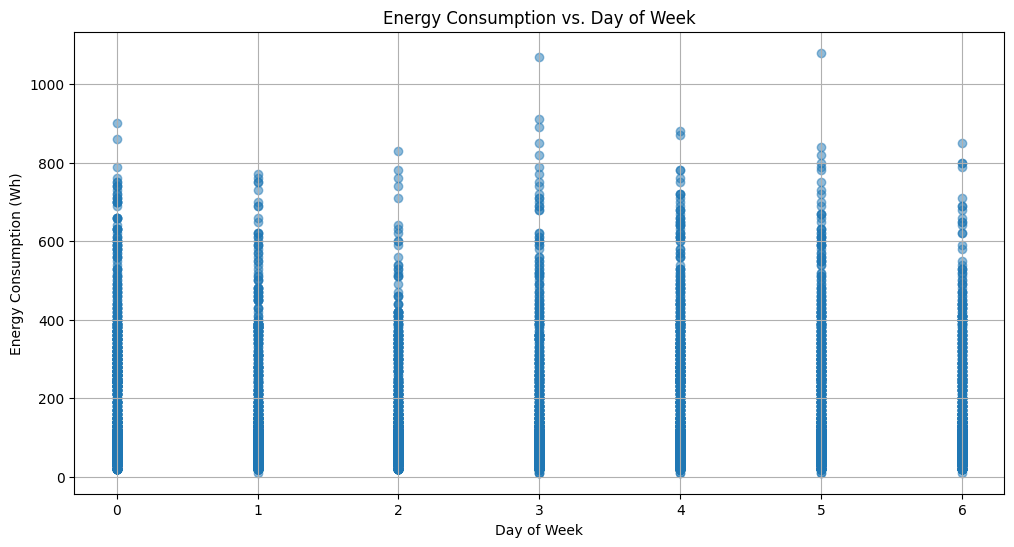

In [34]:
# Plot the impact of hour of the day on energy consumption
plt.figure(figsize=(12, 6))
plt.scatter(data['hour'], data['Appliances'], alpha=0.5)
plt.title('Energy Consumption vs. Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption (Wh)')
plt.grid(True)
plt.show()

# Plot the impact of day of the week on energy consumption
plt.figure(figsize=(12, 6))
plt.scatter(data['day_of_week'], data['Appliances'], alpha=0.5)
plt.title('Energy Consumption vs. Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Energy Consumption (Wh)')
plt.grid(True)
plt.show()


In [38]:
# # Initialize simulation variables
# solar_generation = 400  # Watts/hour
# inverter_capacity = 1000  # Total Wh capacity of the inverter
# inverter_remaining = 0  # Start with a full inverter
# mains_usage = []  # Track energy drawn from mains
# solar_utilized = []  # Track solar energy used
# inverter_usage = []  # Track energy drawn from the inverter
# inverter_state = []  # Track remaining inverter capacity over time

# # Simulate energy distribution
# for demand in data['Appliances']:
#     solar_available = solar_generation
#     used_from_solar = min(demand, solar_available)
#     remaining_demand = demand - used_from_solar
#     used_from_inverter = min(remaining_demand, inverter_remaining)
#     remaining_demand -= used_from_inverter
#     used_from_mains = max(remaining_demand, 0)
    
#     # Update inverter remaining charge
#     inverter_remaining += solar_available - used_from_solar
#     inverter_remaining = min(inverter_remaining, inverter_capacity)  # Cap at max capacity
    
#     # Track results
#     solar_utilized.append(used_from_solar)
#     inverter_usage.append(used_from_inverter)
#     mains_usage.append(used_from_mains)
#     inverter_state.append(inverter_remaining)

# # Add results to the dataset for analysis
# data['Solar_Utilized'] = solar_utilized
# data['Inverter_Usage'] = inverter_usage
# data['Mains_Usage'] = mains_usage
# data['Inverter_Remaining'] = inverter_state

# data[['Appliances', 'Solar_Utilized', 'Inverter_Usage', 'Mains_Usage', 'Inverter_Remaining']].head()
